# Risk Model Results Analysis

This notebook analyzes how well our risk assessment model performs in identifying high-risk packaging scenarios. We examine prediction accuracy, error patterns, and areas where the model needs improvement to better protect against quality issues.

## Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import os
from sklearn.metrics import confusion_matrix

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Loading the model and data

We start by loading the risk model results that include predictions and actual outcomes. This dataset allows us to evaluate how well our risk assessment model identifies potential packaging problems.

In [ ]:
# Define the path to the risk model results
file_path = '../../model_output/risk_model/final_df_for_analysis.parquet'
print(f"Looking for risk model results at: {file_path}")

In [ ]:
# --- Load the final_df DataFrame ---
final_df = None # Initialize to None
try:
    print(f"Attempting to load Parquet file from: {file_path}")
    if os.path.exists(file_path):
        final_df = pd.read_parquet(file_path)
        print("✅ Success! DataFrame loaded successfully.")
        display(final_df.head())
    else:
        print("❌ ERROR: File not found at the specified path. Please double-check the path.")
        
except Exception as e:
    print(f"❌ ERROR: An error occurred while trying to read the Parquet file: {e}")

# Now you can proceed with the analysis code if final_df was loaded
if final_df is not None:
    # ... your analysis code from the previous step goes here ...
    pass

Attempting to load Parquet file from: /Users/ulisesgordillo/Downloads/capstone/ML/model_output/risk_model/final_df_for_analysis.parquet
✅ Success! DataFrame loaded successfully.


,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,PackagesHandled,TotalIncidents,AnomaliesDetected,BadPackagingRate (%),OnTimeDeliveryRate (%),AverageCostPerIncident (€),DateOfReport,PredictedQuality,PredictedQualityProba,ActualQuality
252159,SupplierA,T-Shirt,Polyester,0.12,39,Method1,LayoutB,M,Winter,7786.0,185.0,17.0,8.42,87.44,573.12,2023-10-18,1,0.786795,1
233515,SupplierG,Shorts,Polyester,0.23,20,Method2,LayoutB,M,Summer,1426.0,50.0,7.0,16.55,75.58,637.83,2023-09-26,1,0.586851,1
245649,SupplierH,Shirt,Polyester,0.18,39,Method1,LayoutA,M,Spring,865.0,57.0,11.0,38.62,61.70,563.93,2023-10-10,0,0.300692,1
101085,SupplierE,Dress,Cotton,0.53,17,Method1,LayoutB,XS,Spring,2329.0,81.0,20.0,22.33,67.45,551.40,2023-04-27,0,0.496515,1
235264,SupplierA,Shirt,Polyester,0.15,36,Method2,LayoutB,S,Autumn,8205.0,178.0,21.0,8.10,93.59,532.82,2023-09-28,1,0.816948,1


Now we prepare our risk model results for analysis by creating helpful categories and metrics. This helps us understand different types of prediction errors and their business impact.

In [3]:
if final_df is not None:
    # --- Create 'ResultType' and 'PredictionError' columns ---
    
    def get_result_type(row):
        actual = row['ActualQuality']
        predicted = row['PredictedQuality']
        # Note: 1 = Good/Low Risk, 0 = Bad/High Risk
        if actual == 1 and predicted == 1:
            return 'True Positive (Low Risk OK)'
        elif actual == 0 and predicted == 0:
            return 'True Negative (High Risk OK)'
        elif actual == 0 and predicted == 1:
            return 'False Positive (Missed Risk)' # The dangerous error
        elif actual == 1 and predicted == 0:
            return 'False Negative (Wasted Effort)' # The costly error
        else:
            return 'Unknown'
            
    final_df['ResultType'] = final_df.apply(get_result_type, axis=1)
    final_df['PredictionError'] = np.abs(final_df['ActualQuality'] - final_df['PredictedQualityProba'])
    
    print("Helper columns 'ResultType' and 'PredictionError' created successfully.")
    
    # Display the new columns
    display(final_df[['ActualQuality', 'PredictedQuality', 'ResultType', 'PredictionError']].head())
else:
    print("DataFrame not loaded. Skipping preparation.")

Helper columns 'ResultType' and 'PredictionError' created successfully.


,ActualQuality,PredictedQuality,ResultType,PredictionError
252159,1,1,True Positive (Low Risk OK),0.213205
233515,1,1,True Positive (Low Risk OK),0.413149
245649,1,0,False Negative (Wasted Effort),0.699308
101085,1,0,False Negative (Wasted Effort),0.503485
235264,1,1,True Positive (Low Risk OK),0.183052


In [4]:
if final_df is not None:
    # --- Create 'ResultType' and 'PredictionError' columns ---
    def get_result_type(row):
        actual = row['ActualQuality']
        predicted = row['PredictedQuality']
        # Note: 1 = Good/Low Risk, 0 = Bad/High Risk
        if actual == 1 and predicted == 1: return 'True Positive (Low Risk OK)'
        elif actual == 0 and predicted == 0: return 'True Negative (High Risk OK)'
        elif actual == 0 and predicted == 1: return 'False Positive (Missed Risk)'
        elif actual == 1 and predicted == 0: return 'False Negative (Wasted Effort)'
        else: return 'Unknown'
            
    final_df['ResultType'] = final_df.apply(get_result_type, axis=1)
    final_df['PredictionError'] = np.abs(final_df['ActualQuality'] - final_df['PredictedQualityProba'])
    final_df['PredictionCorrect'] = (final_df['ActualQuality'] == final_df['PredictedQuality'])
    
    print("Helper columns created successfully.")
    display(final_df[['ActualQuality', 'PredictedQuality', 'ResultType', 'PredictionCorrect']].head())
else:
    print("DataFrame not loaded. Skipping preparation.")

Helper columns created successfully.


,ActualQuality,PredictedQuality,ResultType,PredictionCorrect
252159,1,1,True Positive (Low Risk OK),True
233515,1,1,True Positive (Low Risk OK),True
245649,1,0,False Negative (Wasted Effort),False
101085,1,0,False Negative (Wasted Effort),False
235264,1,1,True Positive (Low Risk OK),True


## Analysis

Let's dive into analyzing our risk model's performance. We'll examine where it successfully identifies risks and where it makes dangerous mistakes that could lead to quality problems.

### Tables

These detailed tables help us understand specific error patterns. We focus on the most dangerous mistakes - cases where high-risk scenarios were missed - and patterns in wasted effort.

Missed risks are the most critical errors - situations where our model predicted low risk but problems actually occurred. Understanding these helps prevent future quality issues and customer dissatisfaction.

In [5]:
if final_df is not None:
    fp_df = final_df[final_df['ResultType'] == 'False Positive (Missed Risk)']
    
    if not fp_df.empty:
        print(f"Total Missed Risks (False Positives): {len(fp_df)}\n")

        # By Supplier
        print("--- Top 5 Suppliers Involved in Missed Risks ---")
        display(fp_df['SupplierName'].value_counts().nlargest(5).to_frame())

        # By Garment Type
        print("\n--- Top 5 Garment Types Involved in Missed Risks ---")
        display(fp_df['GarmentType'].value_counts().nlargest(5).to_frame())
    else:
        print("No 'Missed Risk' errors found in the dataset.")
else:
    print("DataFrame not loaded. Skipping analysis.")

Total Missed Risks (False Positives): 7392

--- Top 5 Suppliers Involved in Missed Risks ---


,count
SupplierName,
SupplierA,3123
SupplierB,3061
SupplierG,799
SupplierE,409
SupplierC,0



--- Top 5 Garment Types Involved in Missed Risks ---


,count
GarmentType,
Shirt,1545
Pants,1174
Jacket,738
T-Shirt,696
Dress,628


Wasted effort represents situations where we flagged something as high-risk but it turned out fine. While less critical than missed risks, these false alarms reduce efficiency and increase unnecessary costs.

In [6]:
if final_df is not None:
    fn_df = final_df[final_df['ResultType'] == 'False Negative (Wasted Effort)']
    
    if not fn_df.empty:
        print(f"Total Wasted Effort instances (False Negatives): {len(fn_df)}\n")

        # By Supplier
        print("--- Top 5 Suppliers Involved in Wasted Effort ---")
        display(fn_df['SupplierName'].value_counts().nlargest(5).to_frame())

        # By Garment Type
        print("\n--- Top 5 Garment Types Involved in Wasted Effort ---")
        display(fn_df['GarmentType'].value_counts().nlargest(5).to_frame())
    else:
        print("No 'Wasted Effort' errors found in the dataset.")
else:
    print("DataFrame not loaded. Skipping analysis.")

Total Wasted Effort instances (False Negatives): 48939

--- Top 5 Suppliers Involved in Wasted Effort ---


,count
SupplierName,
SupplierC,15612
SupplierD,10303
SupplierE,6527
SupplierF,6322
SupplierB,5612



--- Top 5 Garment Types Involved in Wasted Effort ---


,count
GarmentType,
Shirt,9630
Pants,7134
Jacket,4986
T-Shirt,4614
Dress,3736


Let's investigate cases where heavy items caused our risk model the most difficulty. These "hidden outliers" represent scenarios where product weight significantly challenges our risk assessment accuracy.

In [7]:
if final_df is not None:
    # --- Define and Execute the "Hidden Outlier" Analysis ---
    WEIGHT_THRESHOLD = 1.0
    ERROR_THRESHOLD = 0.7

    print(f"--- Investigating 'Hidden Outliers': High-Error Predictions on Heavy Items ---")
    print(f"Filtering for: Weight > {WEIGHT_THRESHOLD} and PredictionError > {ERROR_THRESHOLD}\n")

    hidden_outliers_df = final_df[
        (final_df['Weight'] > WEIGHT_THRESHOLD) &
        (final_df['PredictionError'] > ERROR_THRESHOLD)
    ].copy()

    if not hidden_outliers_df.empty:
        print(f"Found {len(hidden_outliers_df)} instances of hidden outliers.")

        print("\n--- Suppliers Most Common in this High-Error Group ---")
        display(hidden_outliers_df['SupplierName'].value_counts().to_frame())

        print("\n--- Garment Types Most Common in this High-Error Group ---")
        display(hidden_outliers_df['GarmentType'].value_counts().to_frame())

        print("\n--- What Type of Error Are These Outliers? ---")
        display(hidden_outliers_df['ResultType'].value_counts().to_frame())

        print("\n--- Sample of the Most Confidently Wrong Predictions ---")
        display(hidden_outliers_df.sort_values(by='PredictionError', ascending=False).head(10))
    else:
        print("No packages met the criteria for this specific outlier analysis.")
else:
    print("DataFrame not loaded. Skipping analysis.")

--- Investigating 'Hidden Outliers': High-Error Predictions on Heavy Items ---
Filtering for: Weight > 1.0 and PredictionError > 0.7

Found 1583 instances of hidden outliers.

--- Suppliers Most Common in this High-Error Group ---


,count
SupplierName,
SupplierD,617
SupplierF,482
SupplierC,273
SupplierH,188
SupplierE,22
SupplierG,1
SupplierA,0
SupplierB,0



--- Garment Types Most Common in this High-Error Group ---


,count
GarmentType,
Coat,820
Suit,478
Jacket,156
Hoodie,119
Sweater,10
Blouse,0
Dress,0
Pants,0
Shirt,0



--- What Type of Error Are These Outliers? ---


,count
ResultType,
False Negative (Wasted Effort),1583



--- Sample of the Most Confidently Wrong Predictions ---


,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,PackagesHandled,...,BadPackagingRate (%),OnTimeDeliveryRate (%),AverageCostPerIncident (€),DateOfReport,PredictedQuality,PredictedQualityProba,ActualQuality,ResultType,PredictionError,PredictionCorrect
466590,SupplierH,Suit,Wool,1.18,8,Method3,LayoutE,S,Autumn,847.0,...,40.96,62.77,652.82,2024-06-22,0,0.142566,1,False Negative (Wasted Effort),0.857434,False
468691,SupplierH,Suit,Wool,1.38,8,Method3,LayoutE,L,Spring,847.0,...,40.96,62.77,652.82,2024-06-24,0,0.142901,1,False Negative (Wasted Effort),0.857099,False
457350,SupplierH,Suit,Wool,1.11,7,Method3,LayoutE,XL,Summer,847.0,...,40.96,62.77,652.82,2024-06-11,0,0.148012,1,False Negative (Wasted Effort),0.851988,False
39612,SupplierH,Coat,Wool,1.62,9,Method3,LayoutE,S,Summer,876.0,...,40.30,61.70,624.91,2023-02-15,0,0.161642,1,False Negative (Wasted Effort),0.838358,False
33186,SupplierH,Jacket,Wool,1.01,4,Method3,LayoutA,M,Autumn,876.0,...,40.30,61.70,624.91,2023-02-08,0,0.167958,1,False Negative (Wasted Effort),0.832042,False
299862,SupplierH,Jacket,Wool,1.05,6,Method3,LayoutD,XL,Spring,833.0,...,37.10,63.00,621.93,2023-12-12,0,0.168017,1,False Negative (Wasted Effort),0.831983,False
72888,SupplierH,Suit,Wool,1.35,7,Method3,LayoutD,XL,Summer,779.0,...,41.85,62.14,676.44,2023-03-25,0,0.168133,1,False Negative (Wasted Effort),0.831867,False
65100,SupplierH,Coat,Silk,1.21,6,Method3,LayoutE,M,Summer,779.0,...,41.85,62.14,676.44,2023-03-16,0,0.169205,1,False Negative (Wasted Effort),0.830795,False
328465,SupplierH,Suit,Wool,1.19,4,Method3,LayoutC,M,Summer,826.0,...,40.19,61.59,463.19,2024-01-14,0,0.169257,1,False Negative (Wasted Effort),0.830743,False
334338,SupplierH,Suit,Wool,1.27,9,Method3,LayoutE,S,Autumn,826.0,...,40.19,61.59,463.19,2024-01-21,0,0.170793,1,False Negative (Wasted Effort),0.829207,False


### Visualizations

Visual analysis helps us quickly identify patterns and trends in our risk model's performance. These charts reveal which factors are most associated with prediction errors and overall model behavior.

This overview chart shows the distribution of our risk model's predictions. It gives us a quick snapshot of how often the model makes correct predictions versus different types of errors.

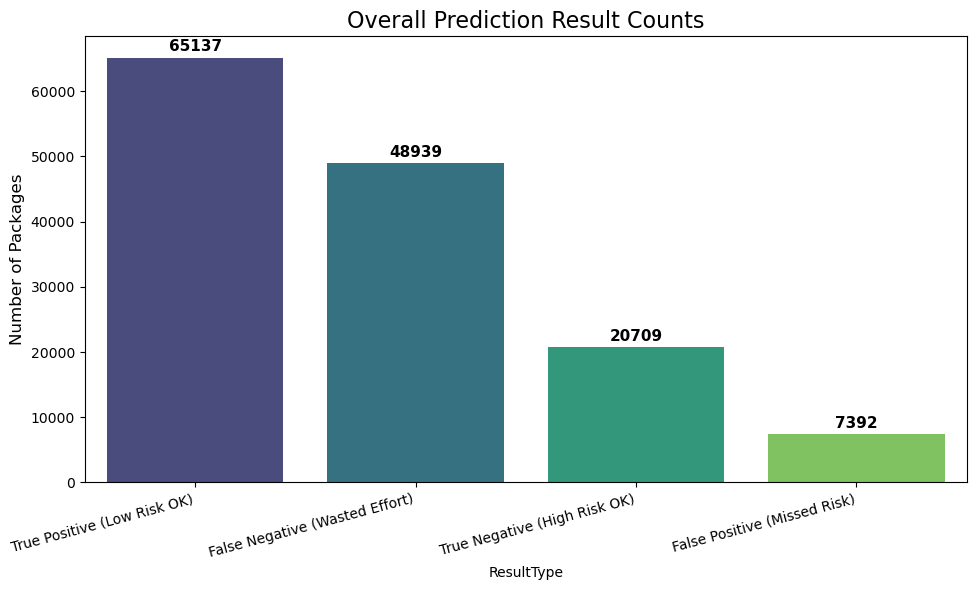

In [8]:
if final_df is not None:
    result_counts = final_df['ResultType'].value_counts()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=result_counts.index, y=result_counts.values, palette='viridis')
    plt.title('Overall Prediction Result Counts', fontsize=16)
    plt.ylabel('Number of Packages', fontsize=12)
    plt.xticks(rotation=15, ha="right")
    
    # Add counts on top of bars
    for index, value in enumerate(result_counts):
        plt.text(index, value + 500, str(value), ha='center', va='bottom', fontsize=11, fontweight='bold')
        
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame not loaded. Skipping analysis.")

These charts show which suppliers and product types are most associated with prediction errors. Understanding these patterns helps us identify where to focus improvement efforts.

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


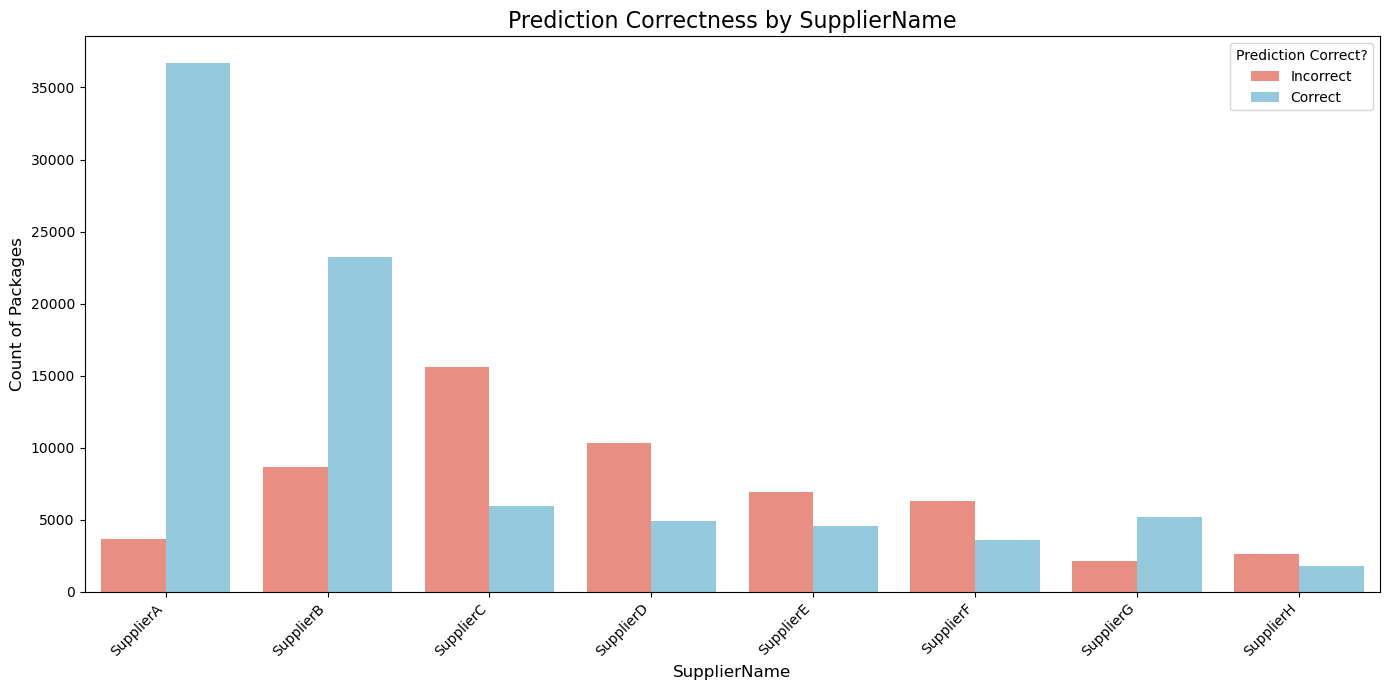

/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


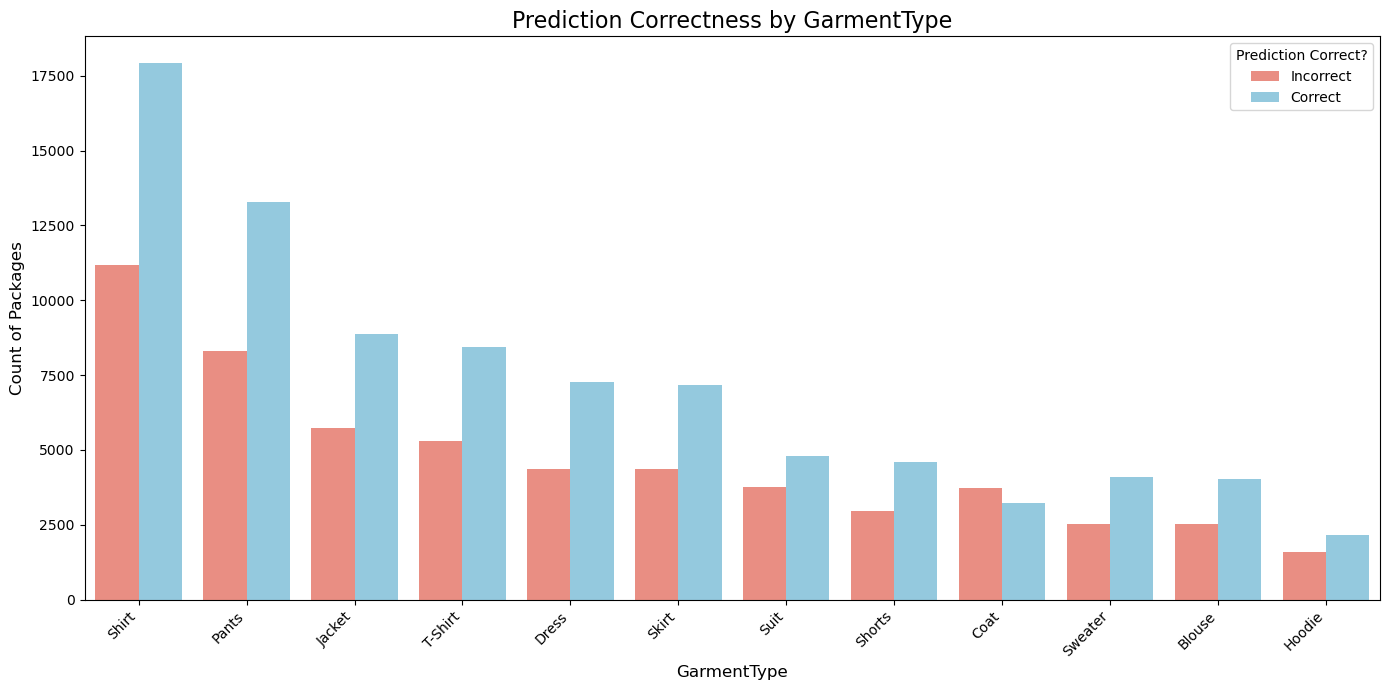

In [9]:
def plot_error_distribution_by_feature(df, feature_col):
    """Compares the distribution of a feature for correct vs. incorrect predictions."""
    plt.figure(figsize=(14, 7))
    
    # Order bars by total count for clarity
    order = df[feature_col].value_counts().index
    
    sns.countplot(data=df, x=feature_col, hue='PredictionCorrect', order=order, palette={True: 'skyblue', False: 'salmon'})
    
    plt.title(f'Prediction Correctness by {feature_col}', fontsize=16)
    plt.xlabel(feature_col, fontsize=12)
    plt.ylabel('Count of Packages', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Prediction Correct?', labels=['Incorrect', 'Correct'])
    plt.tight_layout()
    plt.show()

if final_df is not None:
    # Plot for the most important categorical features
    plot_error_distribution_by_feature(final_df, 'SupplierName')
    plot_error_distribution_by_feature(final_df, 'GarmentType')
else:
    print("DataFrame not loaded. Skipping analysis.")

Model calibration analysis shows how reliable our risk confidence scores are. A well-calibrated model means when it says there's a 70% chance of low risk, that should be accurate about 70% of the time.

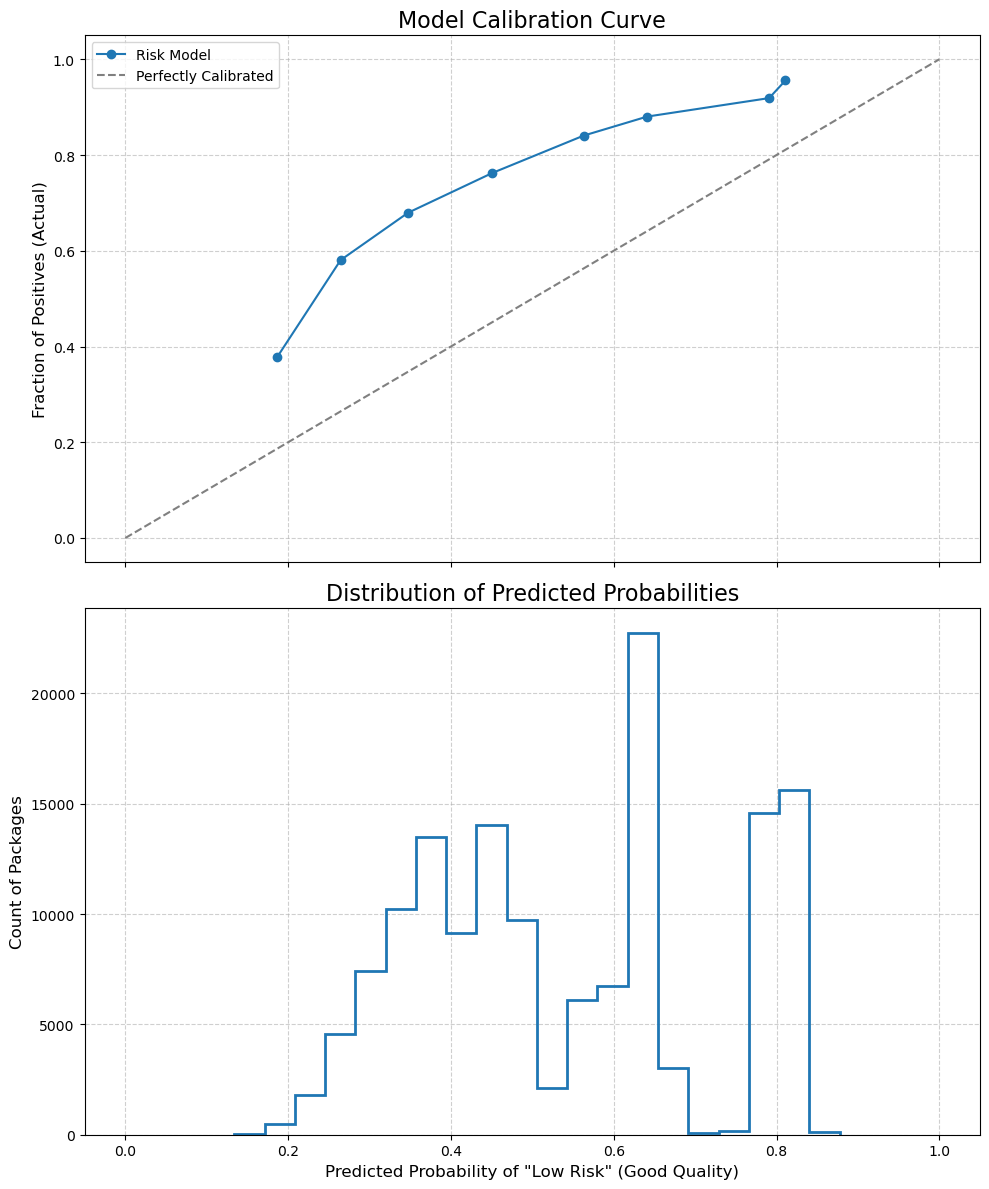

In [10]:
from sklearn.calibration import calibration_curve

if final_df is not None:
    # Get actual outcomes and predicted probabilities for the "Low Risk" class
    y_true = final_df['ActualQuality']
    y_prob = final_df['PredictedQualityProba']
    
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)
    
    # Plot 1: Calibration Curve
    ax1.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Risk Model')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    ax1.set_title('Model Calibration Curve', fontsize=16)
    ax1.set_ylabel('Fraction of Positives (Actual)', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot 2: Histogram of Predicted Probabilities
    ax2.hist(y_prob, bins=20, histtype='step', lw=2, density=False)
    ax2.set_title('Distribution of Predicted Probabilities', fontsize=16)
    ax2.set_xlabel('Predicted Probability of "Low Risk" (Good Quality)', fontsize=12)
    ax2.set_ylabel('Count of Packages', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

else:
    print("DataFrame not loaded. Skipping analysis.")

These scatter plots reveal if certain product characteristics make risk assessment more difficult. Identifying problematic ranges helps us understand when to be extra cautious with risk predictions.

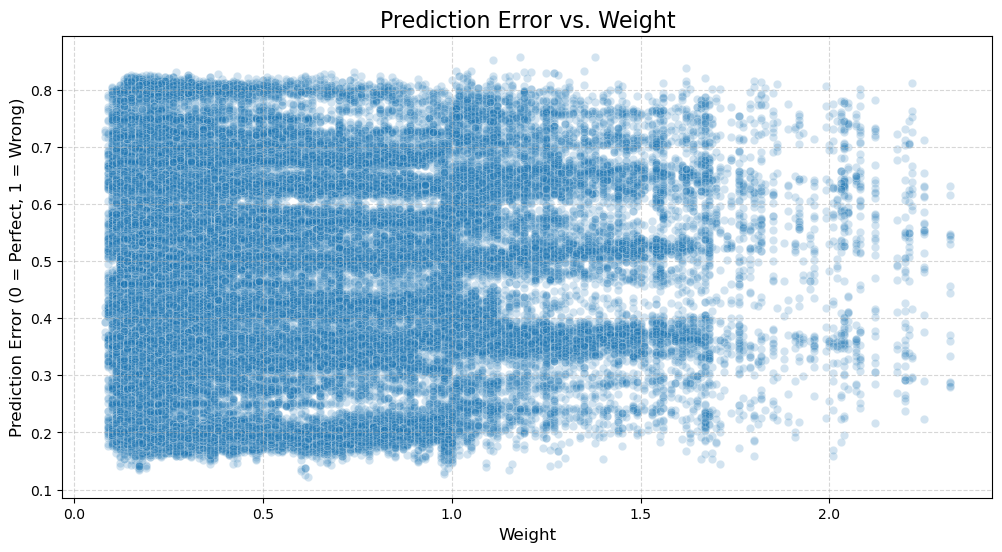

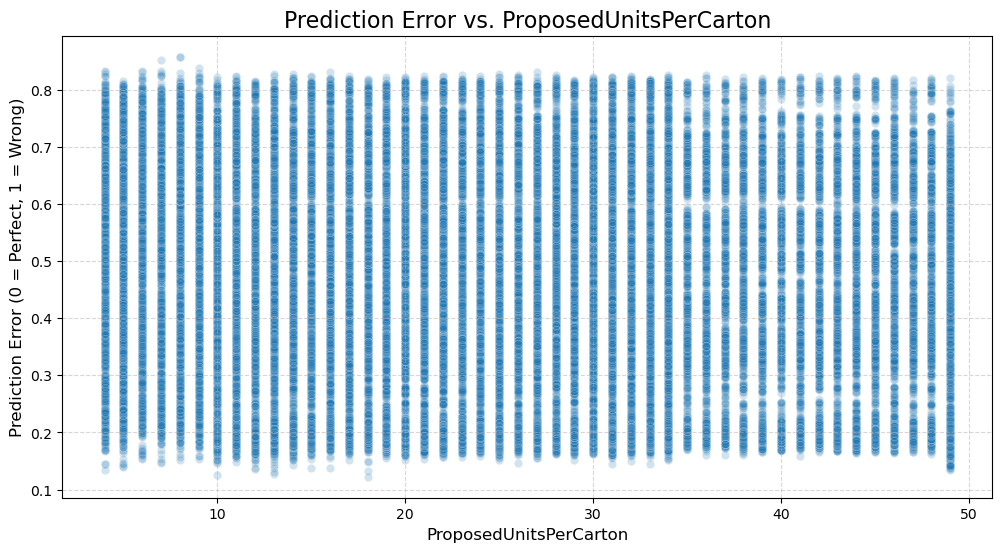

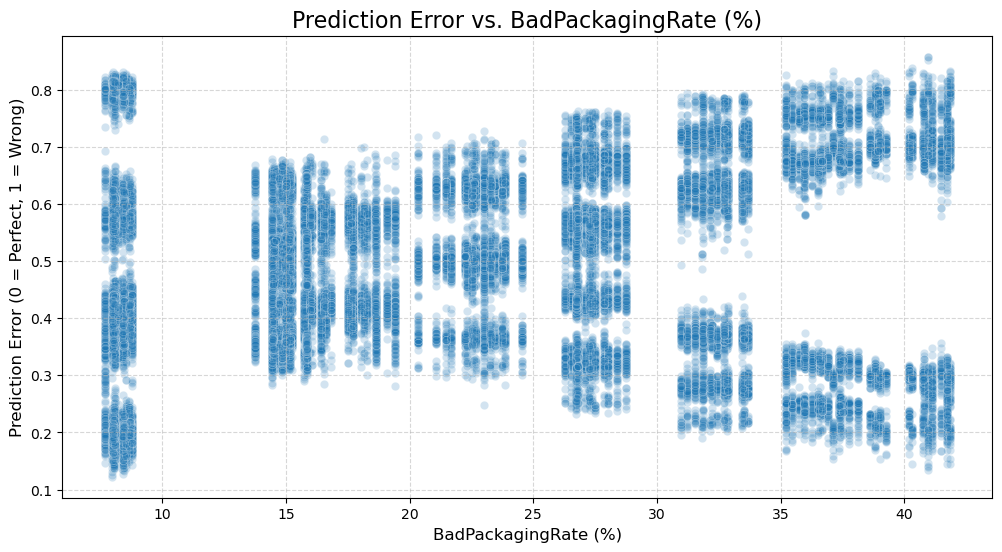

In [11]:
if final_df is not None:
    key_numerical_features = ['Weight', 'ProposedUnitsPerCarton', 'BadPackagingRate (%)']
    
    for feature in key_numerical_features:
        if feature in final_df.columns:
            plt.figure(figsize=(12, 6))
            # Use alpha for transparency to see density
            sns.scatterplot(data=final_df, x=feature, y='PredictionError', alpha=0.2)
            plt.title(f'Prediction Error vs. {feature}', fontsize=16)
            plt.xlabel(feature, fontsize=12)
            plt.ylabel('Prediction Error (0 = Perfect, 1 = Wrong)', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()
else:
    print("DataFrame not loaded. Skipping analysis.")